In [46]:
%load_ext autoreload
import sys
sys.path.append("../..")

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import darkhistory.physics as phys

# $z>1570$ Evolution

We will borrow the method from Hyrec and pre-Hyrec in which we calculate post-Saha corrections at large redshifts, then solve the differential equation at small redshifts.

We start by defining the (small) devisation from Saha Equilibrium $\Delta x_e = x_e - x_e^S(z)$, then Taylor expanding the ODE for $\dot{x}_e$:
$$ \dot{x}_e(x_e, z) = \dot{x}_e(x_e^S, z) + D_1 \Delta x_e + \mathcal{O}(\Delta x_e^2) $$

To solve for the coefficient $D_1$ we perform a numerical differentiation with $\epsilon = 0.01 x_e^S(1-x_e^S)$:
$$ D_1 = \frac{\dot{x}_e(x_e+\epsilon, z) - \dot{x}_e(x_e-\epsilon, z)}{2\epsilon} $$

Combining all of our results then gives us
$$ x_e = x_e^S(z) + \frac{\dot{x}_e(x_e, z) - \dot{x}_e(x_e^S, z)}{D_1(z)} + \mathcal{O}(\Delta x_e^2) $$

This isn't quite good enough, since it's an implicit equation for $x_e$, so we replace the numerator of the second term by $\dot{x}_e^S(z)$ (!!! Consistent?) to find
$$ x_e \approx x_e^S(z) + \frac{\dot{x}_e^S(z) - \dot{x}_e(x_e^S, z)}{D_1(z)} $$

In [239]:
%autoreload

def xdot(xe, rs, fudge = True):
    Tm = phys.Tm_std(rs)
    peebC = phys.peebles_C(xe, rs, fudge)
    beta_ion = phys.beta_ion(Tm, 'HI', fudge)
    nH = phys.nH * rs**3
    xHI = 1-xe

    return - phys.dtdz(rs) * peebC * (
        phys.alpha_recomb(Tm, 'HI', fudge) * xe**2 * nH
        - 4 * beta_ion * xHI * np.exp(-phys.lya_eng/phys.TCMB(rs))
    )

def post_Saha(rs, species = 'HII'):
    xHII_S = phys.xe_Saha(rs, 'HII')
    xHI_S  = phys.xe_Saha(rs, 'HI')

    eps = .01 * xHII_S * xHI_S
    D1 = (xdot(xHII_S + eps, rs) - xdot(xHII_S - eps, rs))/(2*eps)

    if species == 'HII':
        return xHII_S + phys.d_xe_Saha_dz(rs,'HI')/D1

    elif species == 'HI':
        return xHI_S - phys.d_xe_Saha_dz(rs,'HI')/D1

    else:
        raise TypeError('Invalid Species')



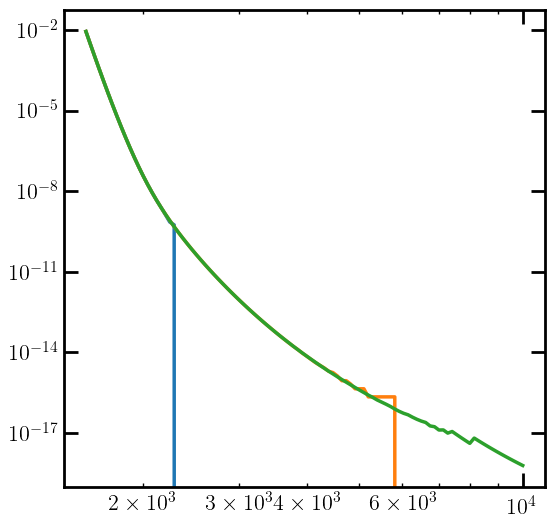

In [244]:
%autoreload

rs_vec = 10**(np.linspace(np.log10(1570), 4, 100))
Tm_vec = phys.Tm_std(rs_vec)

# Baseline, Saha value
xHII_S = phys.xe_Saha(rs_vec, 'HII')
xHI_S  = phys.xe_Saha(rs_vec, 'HI')

# Deviations for Saha
xHII_S1 = post_Saha(rs_vec, 'HII')
xHI_S1 =  post_Saha(rs_vec, 'HI')

eps = .01 * xHII_S * xHI_S
D1 = (xdot(xHII_S + eps, rs_vec) - xdot(xHII_S - eps, rs_vec))/(2*eps)


plt.figure()
plt.loglog()
ax = plt.gca()
# ax.set_xscale('log')
# plt.ylim([1e-100,1e-2])

plt.plot(rs_vec, np.abs((1-xHII_S)/(1-xHII_S1) - 1))
plt.plot(rs_vec, np.abs(xHI_S/xHI_S1 - 1))
plt.plot(rs_vec, phys.d_xe_Saha_dz(rs_vec,'HI')/D1/xHI_S1)

# plt.plot(rs_vec, 1-xHII_S1)
# plt.plot(rs_vec, phys.xHI_std(rs_vec, rs_extrap=2e3))
# plt.plot(rs_vec, xHI_S1)

# Histories

(i) Saha, then TLA

(ii) Saha + $\delta_{std}$, then TLA

(iii) Saha + $\delta$, then TLA

In [364]:
%autoreload
from darkhistory.history import tla
dlnz = .001
rtol = 1e-8

rs_start = 3e3
rs_knot = 1.57e3
rs_end = 10

rs_high = 10**np.arange(np.log10(rs_start), np.log10(rs_knot)-dlnz, -dlnz)
rs_low  = 10**np.arange(np.log10(rs_knot), np.log10(rs_end) - dlnz, -dlnz)

# In case np.arange did any funny business
rs_high[-1], rs_high[0] = rs_knot, rs_start
rs_low[-1], rs_low[0]  = rs_end, rs_knot

rs_vec = np.append(rs_high[:-1], rs_low)

init_cond = np.array([
    phys.Tm_std(rs_knot), 
    phys.xe_Saha(rs_knot, 'HII'),
    0,
    0
])

# case (i): Standard
xHII_vec = phys.xe_Saha(rs_high, 'HII')
init_cond[1] = xHII_vec[-1]

hist1 = tla.get_history(
    rs_low, init_cond=init_cond, 
    reion_switch = False,
    recfast_TLA=True, fudge=True, 
    alpha_MLA=None, beta_MLA=None,
    mxstep = 10000, rtol=rtol
)

xHII_vec = np.append(xHII_vec[:-1], hist1[:,1])


# case (ii): post_Saha, Peebles
xHI_vec = post_Saha(rs_high, 'HI')
init_cond[1] = 1-xHI_vec[-1]

hist2 = tla.get_history(
    rs_low, init_cond=init_cond, 
    reion_switch = False,
    recfast_TLA=True, fudge=True, 
    alpha_MLA=None, beta_MLA=None,
    mxstep = 10000, rtol=rtol
)

xHI_vec = np.append(xHI_vec[:-1], 1-hist2[:,1])

# case (iii): post_Saha, DH




In [365]:
hist0 = tla.get_history(rs_vec)

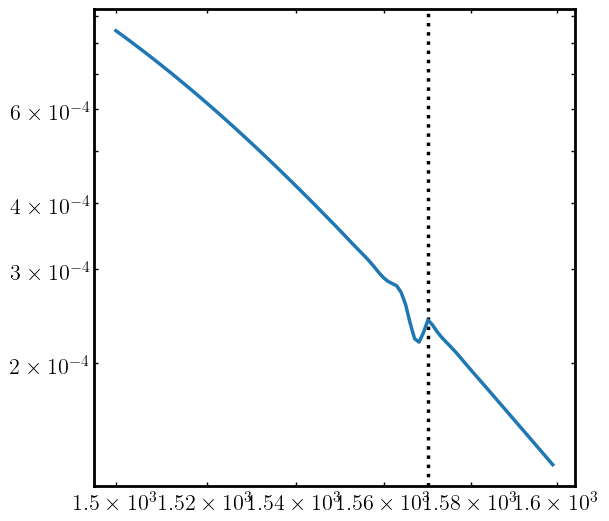

In [378]:
from scipy.interpolate import interp1d

plt.figure()
plt.loglog()

int1 = interp1d(rs_vec, xHI_vec, kind='cubic')
rs_tmp = 10**np.linspace(np.log10(1.5e3), np.log10(1.6e3), 100)

plt.axvline(rs_knot, linestyle=':', color='k')
plt.plot(rs_tmp[:-1], -np.diff(int1(rs_tmp)))
# plt.plot(rs_vec[:-1], -np.diff(1-xHII_vec)/np.diff(rs_vec))
# plt.plot(rs_vec[:-1], -np.diff(xHI_vec)/np.diff(rs_vec))
# plt.plot(rs_vec[:-1], -np.diff(phys.xHI_std(rs_vec))/np.diff(rs_vec))
# plt.plot(rs_vec[:-1], -np.diff(1-hist0[:,1])/np.diff(rs_vec), linestyle=':')